In [1]:
# (1) 
from circuit_sim import circuit_sim

lic_list = [2.4*74.4, 3.5*60.8]
vb_list = [0.5*10**(-3), 0.25*10**(-3)]
ibf_list = [0.4, 0.5]
bc_list = [1, 2]

def run_simulation(i):
    index = bin(i-1)[2:].zfill(4)
    lic = lic_list[int(index[0])]
    vb = vb_list[int(index[1])]
    ibf = ibf_list[int(index[2])]
    bc = bc_list[int(index[3])]
    Ic = 60.8 if lic == 3.5*60.8 else 74.4
    print(f"Start simulation {i} with Ic={Ic}uA, LIc={lic}uA*pH, Vb={vb*(10**3)}mV, Ibfactor={ibf}, Betac={bc}")
    
    sim_con = circuit_sim("jtl_base.cir")
    sim_con.new_make_jtl2(Ic, lic, vb, ibf, bc)
    res_start = sim_con.get_switch_timing(["P(B1|X1|X1|X35)", "P(B2|X1|X1|X35)"])
    res_fin = sim_con.get_switch_timing(["P(B1|X1|X1|X5)", "P(B2|X1|X1|X5)"])
    diff1 = res_fin["time"].iloc[0] - res_start["time"].iloc[0]
    diff2 = res_fin["time"].iloc[1] - res_start["time"].iloc[1]
    base_diff = (diff1 + diff2) / 2
    print(base_diff/40,"ps per SQUID")

if __name__ == "__main__":
    indices = range(1, 16 + 1)
    for i in indices:
        # run_simulation(i)
        pass

In [2]:
def calc_nominal_ic_uA(Ic_uA, L_pH):
    f_q = 2.06783385*(10**(-15))
    Ic_A = Ic_uA*10**(-6)
    L_H = L_pH*10**(-12)
    x = (L_H * Ic_A) / f_q
    result = (0.5263*x**6 -2.3279*x**5 + 3.4434*x**4 - 1.0023*x**3 - 2.5876*x**2 + 3.341*x)*Ic_A
    return result*10**6

/tmp/ipykernel_1580000/3175125143.py:50: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(row["Icn"], row["Std"]*1e12, label=row["Name"],
/tmp/ipykernel_1580000/3175125143.py:50: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(row["Icn"], row["Std"]*1e12, label=row["Name"],


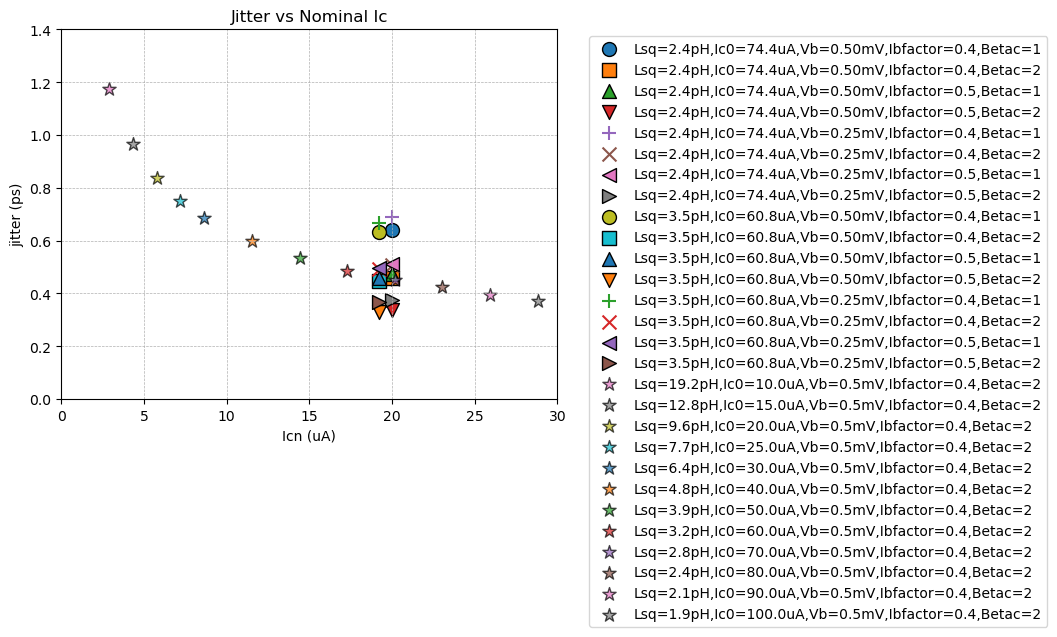

In [3]:
# (2) 臨界電流値毎の遅延ぱらつきヒストグラムの作成
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import norm

plt.rcParams['font.family'] = ''
open("jitter_hstp.csv", "w").close()
xy_data = pd.DataFrame(columns=["Name", "Icn", "Std"])
for i in indices:
    index = bin(i-1)[2:].zfill(4)
    lic = lic_list[int(index[0])]
    vb = vb_list[int(index[1])]
    ibf = ibf_list[int(index[2])]
    bc = bc_list[int(index[3])]
    Ic = 60.8 if lic == 3.5*60.8 else 74.4
    diff_file = f"jitter_hstp/diff_{i}.csv"
    data = pd.read_csv(diff_file)
    mu, std = norm.fit(data)
    std_per_squid = math.sqrt(std*std/40)
    Icn = calc_nominal_ic_uA(Ic, lic/Ic)
    name = f"Lsq={lic/Ic:.1f}pH,Ic0={Ic}uA,Vb={vb*10**3:.2f}mV,Ibfactor={ibf},Betac={bc}"
    # name = f"{lic/Ic:.1f}pH,{Ic}uA,{vb*10**3:.2f}mV,Ibf={ibf},Bc={bc}"
    xy_data = pd.concat([xy_data, pd.DataFrame([[name, Icn, std_per_squid]], columns=["Name", "Icn", "Std"])], ignore_index=True)

    with open("jitter_hstp.csv", "a") as f:
        f.write(f"{lic},{Ic},{vb},{ibf},{bc},0,{std_per_squid}\n")
        
    
    # fig = plt.figure()
    # plt.hist(data, bins=30, density=True, alpha=0.6, color='g', label="Histogram")
    # xmin, xmax = plt.xlim()
    # x = np.linspace(xmin, xmax, 100)
    # p = norm.pdf(x, mu, std)
    # plt.plot(x, p, 'r', linewidth=2, label="Fitted Normal Distribution")
    # plt.xlabel("Jitter Value")
    # plt.ylabel("Density")
    # plt.title("Fractuation of Propagation Time")
    # plt.legend()
    # plt.savefig(f"jitter_hstp/jitter_{i}.png")
    # # plt.show()
    # plt.close()

fig = plt.figure()
# marker_styles = ['o', 's', '^', 'D', 'v', 'p', '*', 'h', 'x', '+', '<', '>']
marker_styles = ['o', 's', '^', 'v', '+', 'x', '<', '>']

for idx, row in xy_data.iterrows():
    plt.scatter(row["Icn"], row["Std"]*1e12, label=row["Name"],
                marker=marker_styles[idx % len(marker_styles)],
                s=100,
                edgecolors='black',
                alpha=1.0,
                )

past_file = "jitter_rev.csv"
past_data = pd.read_csv(past_file, names=["LIc", "Ic", "Mu", "Std"])
for idx, row in past_data.iterrows():
    lic = row["LIc"]
    Ic = row["Ic"]
    name = f"Lsq={lic/Ic:.1f}pH,Ic0={Ic}uA,Vb=0.5mV,Ibfactor=0.4,Betac=2"
    # name = f"{lic/Ic:.1f}pH,{Ic}uA,0.5mV,Ibf=0.4,Bc=2"
    Icn = calc_nominal_ic_uA(Ic, lic/Ic)
    if Ic >= 10:
        plt.scatter(Icn, row["Std"]*1e12, label=name,
                    marker='*',
                    s=100,
                    edgecolors='black',
                    alpha=0.7)
    
plt.xlim(0, 30)
plt.ylim(0, 1.4)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title('Jitter vs Nominal Ic')
plt.xlabel('Icn (uA)')
plt.ylabel('jitter (ps)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
plt.show()
plt.close()

/tmp/ipykernel_1580000/1889431533.py:6: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(row["Icn"], row["Std"]*1e12, label=row["Name"],
/tmp/ipykernel_1580000/1889431533.py:6: UserWarning: You passed a edgecolor/edgecolors ('black') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(row["Icn"], row["Std"]*1e12, label=row["Name"],


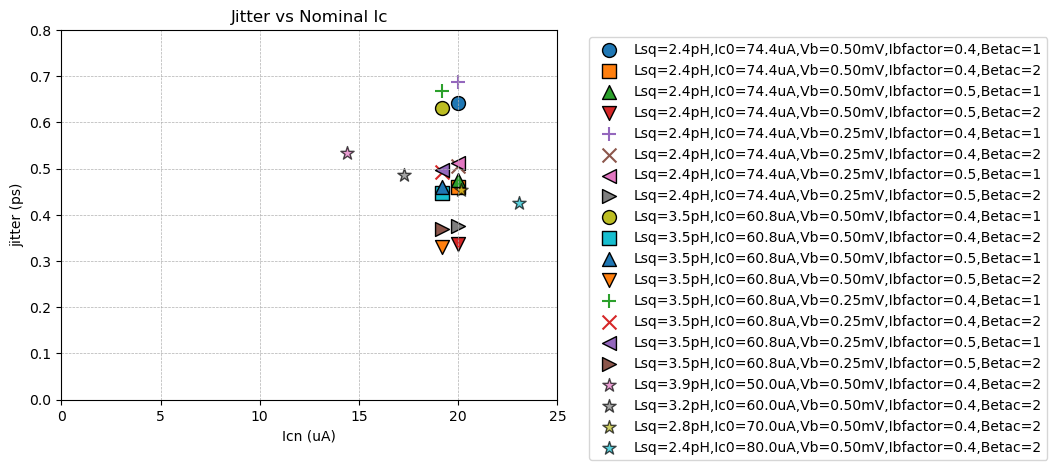

In [6]:
fig = plt.figure()
# marker_styles = ['o', 's', '^', 'D', 'v', 'p', '*', 'h', 'x', '+', '<', '>']
marker_styles = ['o', 's', '^', 'v', '+', 'x', '<', '>']

for idx, row in xy_data.iterrows():
    plt.scatter(row["Icn"], row["Std"]*1e12, label=row["Name"],
                marker=marker_styles[idx % len(marker_styles)],
                s=100,
                edgecolors='black',
                alpha=1.0,
                )

past_file = "jitter_rev.csv"
past_data = pd.read_csv(past_file, names=["LIc", "Ic", "Mu", "Std"])
for idx, row in past_data.iterrows():
    lic = row["LIc"]
    Ic = row["Ic"]
    Lsq = lic / Ic
    name = f"Lsq={Lsq:.1f}pH,Ic0={Ic}uA,Vb=0.50mV,Ibfactor=0.4,Betac=2"
    # name = f"{lic/Ic:.1f}pH,{Ic}uA,0.5mV,Ibf=0.4,Bc=2"
    Icn = calc_nominal_ic_uA(Ic, Lsq)
    if (Ic >= 50) and (Lsq >= 2.4):
        plt.scatter(Icn, row["Std"]*1e12, label=name,
                    marker='*',
                    s=100,
                    edgecolors='black',
                    alpha=0.7)
    
plt.xlim(0, 25)
plt.ylim(0, 0.8)
plt.grid(which='both', linestyle='--', linewidth=0.5)
plt.title('Jitter vs Nominal Ic')
plt.xlabel('Icn (uA)')
plt.ylabel('jitter (ps)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
plt.show()
plt.close()